References used for this notebook: 
1.  https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
2. https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
3. https://github.com/yunjey/pytorch-tutorial/blob/master/tutorials/01-basics/pytorch_basics/main.py
4. https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/

In [1]:
from google.colab import files
files.upload()

Saving pima-indians-diabetes.csv to pima-indians-diabetes.csv


{'pima-indians-diabetes.csv': b'6,148,72,35,0,33.6,0.627,50,1\r\n1,85,66,29,0,26.6,0.351,31,0\r\n8,183,64,0,0,23.3,0.672,32,1\r\n1,89,66,23,94,28.1,0.167,21,0\r\n0,137,40,35,168,43.1,2.288,33,1\r\n5,116,74,0,0,25.6,0.201,30,0\r\n3,78,50,32,88,31.0,0.248,26,1\r\n10,115,0,0,0,35.3,0.134,29,0\r\n2,197,70,45,543,30.5,0.158,53,1\r\n8,125,96,0,0,0.0,0.232,54,1\r\n4,110,92,0,0,37.6,0.191,30,0\r\n10,168,74,0,0,38.0,0.537,34,1\r\n10,139,80,0,0,27.1,1.441,57,0\r\n1,189,60,23,846,30.1,0.398,59,1\r\n5,166,72,19,175,25.8,0.587,51,1\r\n7,100,0,0,0,30.0,0.484,32,1\r\n0,118,84,47,230,45.8,0.551,31,1\r\n7,107,74,0,0,29.6,0.254,31,1\r\n1,103,30,38,83,43.3,0.183,33,0\r\n1,115,70,30,96,34.6,0.529,32,1\r\n3,126,88,41,235,39.3,0.704,27,0\r\n8,99,84,0,0,35.4,0.388,50,0\r\n7,196,90,0,0,39.8,0.451,41,1\r\n9,119,80,35,0,29.0,0.263,29,1\r\n11,143,94,33,146,36.6,0.254,51,1\r\n10,125,70,26,115,31.1,0.205,41,1\r\n7,147,76,0,0,39.4,0.257,43,1\r\n1,97,66,15,140,23.2,0.487,22,0\r\n13,145,82,19,110,22.2,0.245,57,0\r\n5

In [77]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import confusion_matrix,classification_report,roc_curve, roc_auc_score

# 1. Prepare Dataset and DatasetLoader

In [3]:
df = pd.read_csv("/content/pima-indians-diabetes.csv")

In [4]:
df

,6,148,72,35,0,33.6,0.627,50,1
0,1,85,66,29,0,26.6,0.351,31,0
1,8,183,64,0,0,23.3,0.672,32,1
2,1,89,66,23,94,28.1,0.167,21,0
3,0,137,40,35,168,43.1,2.288,33,1
4,5,116,74,0,0,25.6,0.201,30,0
...,...,...,...,...,...,...,...,...,...
762,10,101,76,48,180,32.9,0.171,63,0
763,2,122,70,27,0,36.8,0.340,27,0
764,5,121,72,23,112,26.2,0.245,30,0
765,1,126,60,0,0,30.1,0.349,47,1


In [5]:
df.iloc[:,-1]

0      0
1      1
2      0
3      1
4      0
      ..
762    0
763    0
764    0
765    1
766    0
Name: 1, Length: 767, dtype: int64

In [7]:

rename = {
    '6': 'Pregnancies',
    '148':'Glucose',
    '72':'BloodPressure',
    '35': 'SkinThickness',
    '0':'Insulin',
    '33.6':'BMI',
    '0.627': 'DiabetesPedigreeFunction',
    '50':'Age',
    '1': 'Class'
}
df.rename(columns = rename,inplace=True)

In [8]:
#An important thing to note is that __getitem__() returns a specific type for a single data point (like a tensor, numpy array etc.)
class DiabetesDataset(Dataset):
  '''
  Create dataset from CSV. Will use this to create train dataset and test dataset. 
  The CSV should be preprocessed and subsetted accordingly outside of this class, and the target labels
  should be in the last column.
  '''
  def __init__(self, df):
    self.df = df
    X = df.iloc[:,:-1].values
    Y = df.iloc[:,-1].values
    self.X = torch.from_numpy(X)
    self.Y = torch.from_numpy(Y)
    

  def __len__(self):
    return len(self.df)
  def __getitem__(self,idx):
    if torch.is_tensor(idx):
        idx = idx.tolist()
    return (self.X[idx],self.Y[idx])

In [9]:

df_train, df_test = tts(df, test_size=0.4, random_state=2021, shuffle=True)
print(df_train.shape, df_test.shape)

(460, 9) (307, 9)


In [10]:
train_dataset = DiabetesDataset(df_train)
test_dataset = DiabetesDataset(df_test)

In [11]:
#testing to see if all good
train_dataset.__getitem__(10)
# Seems to work

(tensor([  8.0000, 155.0000,  62.0000,  26.0000, 495.0000,  34.0000,   0.5430,
          46.0000], dtype=torch.float64), tensor(1))

In [43]:
trainloader = DataLoader(train_dataset,batch_size = 16,shuffle = True,num_workers = 2)
testloader = DataLoader(test_dataset,batch_size = 16,shuffle = False,num_workers = 2)

# 2. Define Model

In [13]:
# Defining the model
class LogisticRegression(nn.Module):
  '''
  This is the class for the Logistic Regression model.
  Simply 1 FC followed by sigmoid.
  '''
  def __init__(self):
    super(LogisticRegression,self).__init__()
    self.fc = nn.Linear(in_features = 8,out_features = 1)
    self.sigmoid = nn.Sigmoid()
  def forward(self,x):
    x = self.fc(x)
    x = self.sigmoid(x)
    return x


# 3. Define Loss and Optimizer

In [14]:
model = LogisticRegression()
criterion = nn.BCELoss()
# use stochastic gradient descent here
optimizer = optim.SGD(model.parameters(),lr = 0.0001,momentum = 0.9)

Interestingly enough, Pytorch doesn't have a gradient descent optimizer. All of it is SGD, then whether its batch gradient descent/ mini batch / stochastic, depends on the dataloader or what you feed model in forward pass.

#4. Train Model

In [15]:
def fit(model,num_epochs,dataloader):
  '''
  Fitting the model based on the train set. Specify the dataloader used, as well as the size of the dataset.

  model - model to be fitted
  dataloader - dataloader to use
  num_epochs - number of epochs
  '''
  # Train the model
  dataset_length = len(dataloader.dataset)
  losses = []
  for i in range(num_epochs):
    print("-"*25)
    print(f"Currently training for epoch {i+1}.")
    running_loss = 0
    for idx,data in enumerate(loader):
      # Get the data
      x,y = data
      # y is of shape 8, need to change shape to (8,1) to match with model output shape
      y = y.unsqueeze(1)
      y = y.float()

      # Zero the gradients
      optimizer.zero_grad()

      # Forward Pass
      y_hat = model(x.float())
      # Get Loss
      loss = criterion(y_hat,y)
      # Backward Pass and Optimize
      loss.backward() #Will automatically get gradients for the batch
      optimizer.step()

      # Get the loss and multiply it by the number of samples in the batch
      running_loss += loss.item() * x.shape[0] 

    epoch_loss = running_loss / dataset_length
    print(f"Epoch {i+1} loss : {epoch_loss}")
    losses.append(epoch_loss)
  print("Training finished.")
  return losses

train_loss = fit(model,15,trainloader,df_train.shape[0])

-------------------------
Currently training for epoch 1.
Epoch 1 loss : 47.25955833766771
-------------------------
Currently training for epoch 2.
Epoch 2 loss : 11.615089750289917
-------------------------
Currently training for epoch 3.
Epoch 3 loss : 2.48874482486559
-------------------------
Currently training for epoch 4.
Epoch 4 loss : 1.6129154308982518
-------------------------
Currently training for epoch 5.
Epoch 5 loss : 1.3219599713449892
-------------------------
Currently training for epoch 6.
Epoch 6 loss : 1.6281998494397039
-------------------------
Currently training for epoch 7.
Epoch 7 loss : 1.0090688187143078
-------------------------
Currently training for epoch 8.
Epoch 8 loss : 0.8971029592596966
-------------------------
Currently training for epoch 9.
Epoch 9 loss : 1.1683829779210297
-------------------------
Currently training for epoch 10.
Epoch 10 loss : 0.855245264198469
-------------------------
Currently training for epoch 11.
Epoch 11 loss : 1.00029

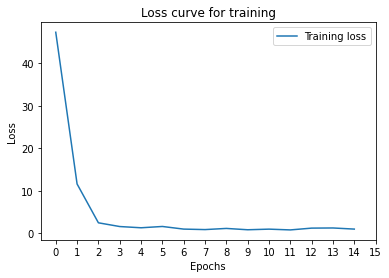

In [16]:
plt.plot(train_loss,label='Training loss')
plt.xticks(np.arange(0,16,1))
plt.title('Loss curve for training')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [80]:
# Save Model
torch.save(model.state_dict(),"LR_model")

In [ ]:
# Load Model
#model = LogisticRegression()
#model.load_state_dict(torch.load(PATH))

#5. Evaluate Model

In [68]:
def predict(model,dataloader,threshold,proba = False):
  '''
  Will return all model predictions on dataloader based on threshold.

  Parameters:
  model,dataloader - model and dataloader to use
  threshold - Only valid if proba = False. Sets threshold to convert probabilities into integer
  proba - False/True, determines whether to return 1s and 0s or probabilities.
  '''
  dataset_length = len(dataloader.dataset)
  with torch.no_grad():
    for idx,data in enumerate(dataloader):
      x,y = data
      pred = model(x.type(torch.float32))
      if not proba:
        pred = (pred > threshold).type(torch.int64)
      if idx == 0:
        out = pred
      else:
        out = torch.cat([out,pred],dim=0)
      #total+= y.size(0)
      # Use torch.Tensor.item() to get a Python number from a tensor containing a single value:
      #correct += (y_hat == y).sum().item()
      #out = out.squeeze()
  return out.squeeze().numpy()
pred = predict(model,testloader,0.5)

1. Classification Report

              precision    recall  f1-score   support

           0       0.82      0.60      0.69       201
           1       0.50      0.75      0.60       106

    accuracy                           0.65       307
   macro avg       0.66      0.67      0.64       307
weighted avg       0.71      0.65      0.66       307

-------------------------
2. Confusion Matrix



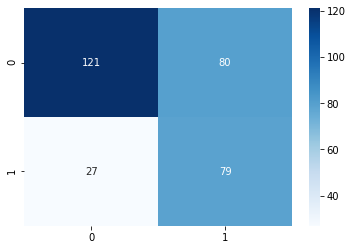

-------------------------
3. ROC-AUC

ROC AUC Score : 0.7305453862761663


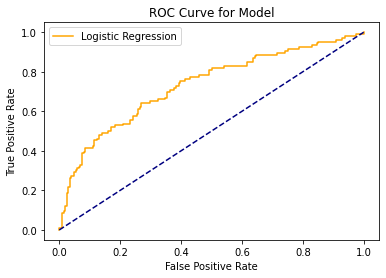

In [76]:
def evaluate(model,dataloader,dataset):
  '''
  Function to evaluate model. Will produce classification report, Confusion Matrix, and finally will show ROC-AUC.

  Parameters:
  model - model to evaluate
  dataloader - the dataloader used. Should be test loader
  dataset - dataset used, should be test dataset
  '''
  # Get model predictions. Pred is integer values based on threshold, pred_proba is the probability
  pred = predict(model,testloader,0.5)
  pred_proba = predict(model,dataloader,0.5,True)

  # Get the true labels
  _,true = test_dataset[:]
  true = true.numpy()

  # Start with classification report
  print("1. Classification Report, based on threshold of 0.5\n")
  print(classification_report(true,pred))
  print("-"*25)

  # Next do confusion matrix
  print("2. Confusion Matrix based on threshold of 0.5\n")
  plt.figure()
  sns.heatmap(confusion_matrix(true,pred),annot=True,fmt= '.3g',cmap='Blues')
  plt.show()
  print("-"*25)

  # Lastly do ROC-AUC
  print("3. ROC-AUC\n")
  # Get AUC score
  auc = roc_auc_score(true,pred_proba)
  print(f"ROC AUC Score : {auc}")

  # Get FPR and TPR, also returns thresholds
  fpr,tpr,_ = roc_curve(true,pred_proba)

  # Plot curves
  plt.figure()
  plt.plot(fpr,tpr,label = 'Logistic Regression',color='orange')
  plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

  # Plot settings
  plt.title("ROC Curve for Model")
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.legend()
  plt.show()


evaluate(model,testloader,test_dataset)

https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/
To make this clear:

* Smaller values on the x-axis of the plot indicate lower false positives and higher true negatives.
* Larger values on the y-axis of the plot indicate higher true positives and lower false negatives.

For a diabetes test, you would rather say one is positive rather than say one is negative, because if the test dismisses as negative its more dangerous than test dismiss as positive. So in this case I think recall is more important?

TP/TP+FN

# To Do:
1. Try to see if can do K-Folds with data loader and all that : 
2. Redesign experiment without using dataset or dataloader.
3. Convert everything into classes
